# Binary Classification Algorithms

## Load data

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/workspaces/credit-card-eligibility/')

from sklearn.model_selection import train_test_split

from lib.data_load import get_data_matrix, plot_target_variable

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('notebooks/dataset.csv')
data.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [4]:
X, y = get_data_matrix(data=data, target = 'Target', excluded_features=['ID'])

In [5]:

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

print(f"""Shape of training data: {X_train.shape}
Shape of test data: {X_test.shape}
""")

# Split the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)
print(f"""Shape of training data: {X_train.shape}
Shape of validation data: {X_val.shape}
""")

Shape of training data: (7767, 18)
Shape of test data: (1942, 18)

Shape of training data: (5825, 18)
Shape of validation data: (1942, 18)



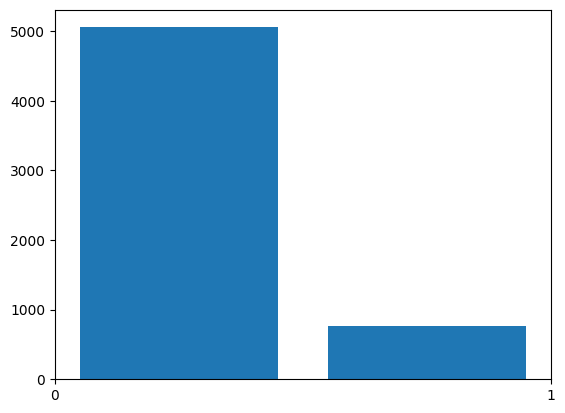

In [6]:
plot_target_variable(y_train=y_train, n_class=2, tick_labels=[0,1])

## Feature Preprocessing

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
numerical_columns = ['Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 'Years_employed']
categorical_columns = ['Income_type', 'Family_status', 'Housing_type', 'Occupation_type'] 
ordinal_columns = ['Education_type']
# For education, I create an order for the categories
education_order = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Academic degree', 'Higher education']

In [9]:
# Create a pipeline that preprocess the data by data types

numerical_transformer = Pipeline(
    steps=[
        ('normalization', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('oe', OrdinalEncoder(categories=[np.array(education_order)]))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_columns),
        ('categorical', categorical_transformer, categorical_columns),
        ('ordinal', ordinal_transformer, ordinal_columns)
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocessing', preprocessor)
    ]
)

In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('normalization',
                                                                   MinMaxScaler())]),
                                                  ['Num_children', 'Num_family',
                                                   'Account_length',
                                                   'Total_income', 'Age',
                                                   'Years_employed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Income_type',
                                                   'Family_status',
                                                   'Housing_type',
                                                   'Occupation_type']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder(categories=[array(['Lower secondary', 'Secondary / secondary special',
       'Incomplete higher', 'Academic degree', 'Higher education'],
      dtype='<U29')]))]),
                                                  ['Education_type'])]))])

In [11]:
pipe.fit_transform(X_train, y_train).toarray()

array([[0.        , 0.16666667, 0.65      , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.15      , ..., 0.        , 0.        ,
        1.        ],
       [0.6       , 0.66666667, 0.78333333, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.05      , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.16666667, 0.7       , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.38333333, ..., 0.        , 0.        ,
        1.        ]])

## Sample Weight for Imbalanced class

In [12]:
y_train_count = pd.DataFrame(y_train.value_counts()).reset_index()
y_train_count['percent'] = y_train_count['count']/ sum(y_train_count['count'])
y_train_count

,Target,count,percent
0,0,5056,0.867983
1,1,769,0.132017


The data is highly imbalanced with Not Eligible, or when Target = 0, is the majority.
Therefore, I use sample weights to train the model with heavier weight on the minority group

In [17]:
# Check the ratio of 0:1
y_train_count.loc[0, 'count']/y_train_count.loc[1, 'count']

6.574772431729519

In [18]:
# I create custom class weight to compare the result with the 'balanced' option for the class_weight parameter
custom_class_weights = {0: 1/6.5, 1: 1}

## Create Baseline

In [19]:
# I generate a random sample of 0s and 1s as prediction then calculate ROC AUC score as baseline
size = y_test.shape[0]
p = y_train_count.iloc[1,2]

np.random.seed(2)
y_baseline = np.random.binomial(n=1, p=p, size=size)

In [23]:
print(classification_report(y_test, y_baseline))
print(f"Baseline's ROC AUC score: {roc_auc_score(y_test, y_baseline)}")

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1685
           1       0.11      0.11      0.11       257

    accuracy                           0.76      1942
   macro avg       0.49      0.49      0.49      1942
weighted avg       0.76      0.76      0.76      1942

Baseline's ROC AUC score: 0.4875775034927086


## GridSearch CV

In [24]:
from sklearn.model_selection import GridSearchCV

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


In [25]:
pipe_lr = Pipeline([('preprocessing', preprocessor),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('preprocessing', preprocessor),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('preprocessing', preprocessor),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('preprocessing', preprocessor),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessing', preprocessor),
                     ('SVM', svm.SVC(random_state=42))])


In [33]:
param_range = [0, 1, 2, 3, 4, 5, 6]

lr_param_grid = [{'LR__class_weight': ['balanced', custom_class_weights]}]
rf_param_grid = [{'RF__class_weight': ['balanced', custom_class_weights],
                  'RF__criterion': ['log_loss', 'entropy']
                  }]
knn_param_grid = [{'KNN__n_neighbors': [3, 5],
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]

svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range,
                    'SVM__class_weight': ['balanced', custom_class_weights]}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:],
                   'DT__class_weight': ['balanced', custom_class_weights]}]

In [34]:
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=3)

rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='roc_auc',
        cv=3)

knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='roc_auc',
        cv=3)

svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='roc_auc',
        cv=3)

dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='roc_auc',
        cv=3)

In [35]:
grids = [lr_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, dt_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

In [36]:
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'KNN', 3: 'SVM', 4: 'Decision Tree'}

for i, model in enumerate(grids):
    print('{} Test ROC AUC: {}'.format(grid_dict[i], model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test ROC AUC: 0.5778868246948932
Logistic Regression Best Params: {'LR__class_weight': {0: 0.15384615384615385, 1: 1}}
Random Forest Test ROC AUC: 0.5650163377939936
Random Forest Best Params: {'RF__class_weight': 'balanced', 'RF__criterion': 'log_loss'}
KNN Test ROC AUC: 0.5220081053932039
KNN Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}
SVM Test ROC AUC: 0.5805632209123762
SVM Best Params: {'SVM__C': 1, 'SVM__class_weight': {0: 0.15384615384615385, 1: 1}, 'SVM__kernel': 'linear'}
Decision Tree Test ROC AUC: 0.5791130252052327
Decision Tree Best Params: {'DT__class_weight': 'balanced', 'DT__criterion': 'entropy', 'DT__max_depth': 4, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
